# South Africa

CAMS PM2.5: Original resolution: 40km x 40km. Improved resolution: 10km x 10km.

Predictors used at the moment:
* DEM

In [1]:
# Built-in modules
import os
import gzip
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import glob
import re
import warnings
from collections import defaultdict

# Basics of Python data handling and visualization
import fs
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm
from shapely import wkt
import rasterio as rio
from shapely import geometry
from rasterstats import zonal_stats
import seaborn as sns

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate, GroupKFold
import statistics 

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOPatch, EOTask, LinearWorkflow, FeatureType, AddFeature, MapFeatureTask, MergeFeatureTask, RemoveFeature,LoadTask, SaveTask, OverwritePermission
from sentinelhub import bbox_to_dimensions, bbox_to_resolution
from eolearn.io import ExportToTiff

# Visualisation utils
from utils import (get_extent, 
                   draw_outline, 
                   draw_bbox, 
                   draw_feature, 
                   draw_true_color,
                   unzip_file,
                   load_tiffs,
                   days_to_datetimes,
                   datetimes_to_days,
                   reproject_tiff,
                   upscale_tiff,
                   mask_tiff)# South Africa

from utils_carles import polygrid, export_geotiff, percs_landuse, upscale_mean_tiff, extract_points_from_raster

In [2]:
DATA_DIR = Path('training_dataset_south_africa')
AOIS = ['South_Africa']

In [3]:
OFFSET = 2100
NO_DATA_VALUE = -9999.0

In [4]:
# CHANGE THIS VALUE to True IF PRE-PROCESSING NEEDS TO BE DONE
preproc = False

## Pre-processing (training data)

Prepare CAMS data. I do not do any temporal adjustment because we're using DEM for now. EPSG=4326.

In [13]:
# Read CAMS PM2.5
cams_train_dir = DATA_DIR/AOIS[0]/'CAMS'
cams_train_eop = load_tiffs(cams_train_dir/'PM2_5', 
                            (FeatureType.DATA, 'PM2_5'), 
                            offset=OFFSET,
                            data_source='cams') 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys


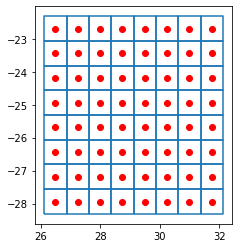

In [6]:
# Create rectangular grid for pixels corresponding to CAMS
bounds = list(cams_train_eop.bbox)
res = (bounds[2]-bounds[0])/cams_train_eop.data["PM2_5"].shape[1]
bounds = geometry.box(bounds[0], bounds[1], bounds[2], bounds[3])
bounds = gpd.GeoDataFrame({"id":1,"geometry":[bounds]}, crs="EPSG:4326")
CAMS_grid = polygrid(bounds, res, 4326)
CAMS_centroids = gpd.GeoDataFrame(geometry= CAMS_grid.centroid)
p = CAMS_grid.boundary.plot()
CAMS_centroids.plot(ax=p, color='red')
plt.show()

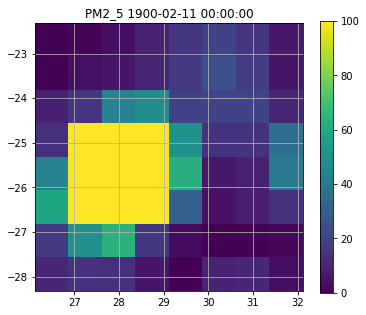

In [8]:
# Draw a sample
fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=cams_train_eop, 
                 feature=(FeatureType.DATA, 'PM2_5'), 
                 time_idx=8, 
                 vmin=0, vmax=100)
fig.colorbar(fh, ax=ax);

Prepare DEM data at 1km resolution to make computations easier. EPSG=4326

In [9]:
# Resampling DEM to 1 Km with the same bounding box of CAMS to make it manageable. Use custom function to use mean.
if preproc:
    # Get resampling dimensions
    target_size = bbox_to_dimensions(cams_train_eop.bbox, 1000)

    # Sampling files to 40 km using bilinear interpolaiton
    path_in = str(DATA_DIR/AOIS[0])+'/DEM/COP_DSM_south_africa_GLO-30.tif'
    path_out = str(DATA_DIR/AOIS[0])+'/DEM/DEM_1km.tif'
    upscale_mean_tiff(path_in, path_out, target_size)

Now compute mean DEM per CAMS pixel

In [10]:
# Read resampled DEM at 1 km
if preproc:
    dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
    dem_train_eop = load_tiffs(datapath=dem_train_dir,
                              feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                              filename='DEM_1km.tif',
                              no_data_value=128)
    
    # Perform zonal statistics - mean altitude per CAMS pixel
    src = rio.open(str(dem_train_dir) + '/DEM_1km.tif')
    affine = src.transform
    array = dem_train_eop.data_timeless['DEM']
    array = array[:, :, 0] # Remove one dimension
    dem_grid = CAMS_grid
    zstats = zonal_stats(dem_grid, array, affine=affine, stats="mean", nodata=np.nan)
    vals = []
    for index, value in enumerate(zstats):
        vals.append(value['mean'])
    dem_grid['elevation'] = vals

In [11]:
# Now we can rasterize
if preproc:
    minx, miny, maxx, maxy = CAMS_grid.geometry.total_bounds
    sizey = round((maxy-miny)/res)
    sizex = round((maxx-minx)/res)
    transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
    shapes = ((geom, value) for geom, value in zip(dem_grid.geometry, dem_grid['elevation']))
    dem = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
    dem
    export_geotiff(str(dem_train_dir) + '/DEM_CAMS.tif', dem, transform, 4326)

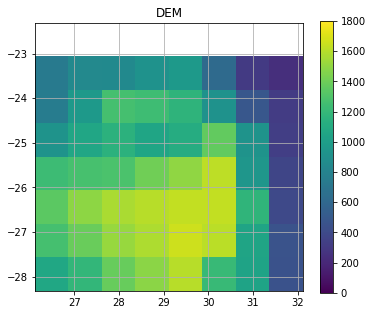

In [12]:
# Read and visualize
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_train_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                           filename='DEM_CAMS.tif')

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=dem_train_eop, 
                 feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
                 time_idx=None, 
                 vmin=0, vmax=1800)
fig.colorbar(fh, ax=ax);

### Prepare ERA5

In [ ]:
# load ERA5 
era5_train_dir = DATA_DIR/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_train_dir))

# Load data
era5_eops = [load_tiffs(era5_train_dir/era5_p, 
                        (FeatureType.DATA, era5_p), 
                        offset=OFFSET, 
                        image_dtype=np.float32,
                        data_source='era5') 
             for era5_p in era5_products]

# Merge into one EOPS
era5_eop = EOPatch(data={'relative_humidity': era5_eops[0].data['relative_humidity'], 
                         'specific_rain_water_content': era5_eops[1].data['specific_rain_water_content'],
                        'wind_u': era5_eops[2].data['wind_u'],
                        'wind_v': era5_eops[3].data['wind_v']},
                   meta_info={'Names_relative_humidity': era5_eops[0].meta_info['Names'],
                              'Names_specific_rain_water_content': era5_eops[1].meta_info['Names'],
                             'Names_wind_u': era5_eops[2].meta_info['Names'],
                             'Names_wind_v': era5_eops[3].meta_info['Names']},
                     timestamp=era5_eops[0].timestamp,
                     bbox=era5_eops[0].bbox)
del era5_eops
era5_eop

In [ ]:
# Perform zonal statistics - ERA5 products per CAMS pixel
# Rastrize the new CAMS zonal stats and save them on disk

era5_location=  str(DATA_DIR/AOIS[0])+'/era5'

## location of exported tiff (ERA5 matching CAMS grid)
era5_cams_location = str(DATA_DIR/AOIS[0])+'/rastrize_era5_cams'
if not os.path.isdir(era5_cams_location):
    os.makedirs(era5_cams_location)
    for i in era5_products:
        os.mkdir(era5_cams_location + '/' + i)    

for era5_p in era5_products:
    i=0
    for era5_path in glob.glob(str(era5_location) + '/' + era5_p + '/' +  '*.tif'):
        src = rio.open(era5_path)
        affine = src.transform
        array = era5_eop.data[era5_p][i]
        array = array[:, :, 0]
        era5_grid = CAMS_grid
        era5_stats = zonal_stats(era5_grid, array, affine=affine, stats="mean", nodata=np.nan)
        
        vals = []
        for index, value in enumerate(era5_stats):
            vals.append(value['mean'])
            
        era5_grid[era5_p] = vals
        
        # rasterize
        minx, miny, maxx, maxy = CAMS_grid.geometry.total_bounds
        sizey = round((maxy-miny)/res)
        sizex = round((maxx-minx)/res)

        transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
        shapes = ((geom, value) for geom, value in zip(era5_grid.geometry, era5_grid[era5_p]))
        era5 = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
        tiffname = era5_eop.meta_info['Names_'+ era5_p][i]
        export_geotiff(str(era5_cams_location) + '/' +era5_p + '/'+ tiffname, era5, transform, 4326)

    
        i+=1

del era5_eop

In [ ]:
## Read rastraized CAMS 

# Prepare directory and product list
era5_train_dir = DATA_DIR/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_train_dir))

era5_cams_location = str(DATA_DIR/AOIS[0])+'/rastrize_era5_cams'
ras_era5_location=Path(era5_cams_location)

# Load data
ras_era5_eops = [load_tiffs(ras_era5_location/era5_p, 
                        (FeatureType.DATA, era5_p), 
                        offset=OFFSET, 
                        image_dtype=np.float32,
                        data_source='era5') 
             for era5_p in era5_products]



# Merge into one EOPS
ras_era5_eop = EOPatch(data={'relative_humidity': ras_era5_eops[0].data['relative_humidity'], 
                              'specific_rain_water_content': ras_era5_eops[1].data['specific_rain_water_content'],
                              'wind_u': ras_era5_eops[2].data['wind_u'],
                              'wind_v': ras_era5_eops[3].data['wind_v']},
                        meta_info={'Names_relative_humidity': ras_era5_eops[0].meta_info['Names'],
                                   'Names_specific_rain_water_content':ras_era5_eops[1].meta_info['Names'],
                                   'Names_wind_u': ras_era5_eops[2].meta_info['Names'],
                                   'Names_wind_v': ras_era5_eops[3].meta_info['Names']},
                        timestamp= ras_era5_eops[0].timestamp,
                        bbox= ras_era5_eops[0].bbox)

del ras_era5_eops
ras_era5_eop

In [ ]:
## plot rastraized CAMS 

fig, axs = plt.subplots(figsize=(25, 5), ncols=4)

time_idx = 1

normalisations = [dict(vmin=np.min(ras_era5_eop.data[era5_p]), 
                       vmax=np.max(ras_era5_eop.data[era5_p])) 
                  for era5_p in era5_products]

for nn, (fname, norm) in enumerate(zip(era5_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=ras_era5_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

# Data merging

Now that everything is in the same format, we need to create our training datasets to start modelling.

In [13]:
# Extract DEM
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
if preproc:
    raster_path = str(dem_train_dir) + '/DEM_CAMS.tif'
    dem_df = extract_points_from_raster(CAMS_centroids, raster_path, 'DEM')
    dem_df = dem_df.dropna()
    dem_df = dem_df.drop('raster', 1)

In [14]:
# Extract CAMS

cams_train_dir = DATA_DIR/AOIS[0]/'CAMS'
CAMS_df = []
for CAMS_path in glob.glob(str(cams_train_dir) + '/PM2_5/*.tif'):
    it_df = extract_points_from_raster(CAMS_centroids, CAMS_path, 'CAMS')
    CAMS_df.append(it_df)

CAMS_df = pd.concat(CAMS_df)


In [ ]:
# Extract ERA5
mean_era5_cams_location = str(DATA_DIR/AOIS[0])+'/rastrize_era5_cams'


def exera5(era5_p):
    era5_df = []
    for era5_path in glob.glob(str(mean_era5_cams_location) + '/'+ era5_p +'/*.tif'):
        it_df = extract_points_from_raster(CAMS_centroids, era5_path, era5_p)
        era5_df.append(it_df)
    era5_df = pd.concat(era5_df)
    return era5_df

relative_humidity_df = exera5('relative_humidity')
specific_rain_water_content_df = exera5('specific_rain_water_content')
wind_u_df = exera5('wind_u')
wind_v_df = exera5('wind_v')

relative_humidity_df = relative_humidity_df.dropna()
specific_rain_water_content_df = specific_rain_water_content_df.dropna()
wind_u_df = wind_u_df.dropna()
wind_v_df = wind_v_df.dropna()

In [ ]:
## Extract the tiff names

CAMS_df['raster'] = CAMS_df['raster'].replace(str(cams_train_dir) + '/PM2_5/','',regex=True)

for era5_p, name in [(relative_humidity_df,'relative_humidity'),(specific_rain_water_content_df,'specific_rain_water_content'),(wind_u_df,'wind_u'),(wind_v_df,'wind_v')]:
    era5_p['raster'] = era5_p['raster'].replace(str(mean_era5_cams_location) + '/' + name + '/','',regex=True)


In [ ]:
### Extract the day and time of observations 

day_hour_df=[CAMS_df,relative_humidity_df,specific_rain_water_content_df,wind_u_df,wind_v_df]
for df in day_hour_df:
    df['day']=np.nan
    df['hour']=np.nan
    df['dayhour']=""
    for i in range(df.shape[0]):
        tiff_name = df.iloc[i]['raster']
        day, hour = tiff_name.split('_day')[-1].split('_')
        
        df.iat[i,df.columns.get_loc('day')] = day
        df.iat[i,df.columns.get_loc('hour')] = hour[1:3]
        df.iat[i,df.columns.get_loc('dayhour')] = str(day)+str(hour[1:3])
        
CAMS_df = CAMS_df.drop('raster', 1)
relative_humidity_df = relative_humidity_df.drop('raster', 1)
specific_rain_water_content_df = specific_rain_water_content_df.drop('raster', 1)
wind_u_df = wind_u_df.drop('raster', 1)
wind_v_df = wind_v_df.drop('raster', 1)

In [ ]:
# write to disk each data frame

for df,name in [(CAMS_df,'CAMS_df.csv'),(relative_humidity_df,'relative_humidity_df.csv'),(specific_rain_water_content_df,'specific_rain_water_content_df.csv'),(wind_u_df,'wind_u_df.csv'),(wind_v_df,'wind_v_df.csv')]:
    df.to_csv(str(DATA_DIR) + '/'+name)

In [15]:
# Inner join by time & coordinates (CAMS & ERA5)
train_df = pd.merge(CAMS_df, relative_humidity_df, on=['day','hour','lon', 'lat'], how='inner')
train_df = pd.merge(train_df, specific_rain_water_content_df, on=['day','hour','lon', 'lat'], how='inner')
train_df = pd.merge(train_df, wind_u_df, on=['day','hour','lon', 'lat'], how='inner')
train_df = pd.merge(train_df, wind_v_df, on=['day','hour','lon', 'lat'], how='inner')

# Inner join by coordinates

if preproc:
    train_df = pd.merge(train_df, dem_df, on=['lon', 'lat'], how='inner')

    
#write to disk
train_df.to_csv(str(DATA_DIR) + '/training_data.csv')

In [5]:
# Read data
train_df = pd.read_csv(str(DATA_DIR) + '/training_data.csv', index_col=0)


CAMS_df = pd.read_csv(str(DATA_DIR) + '/CAMS_df.csv', index_col=0)
relative_humidity_df = pd.read_csv(str(DATA_DIR) + '/relative_humidity_df.csv', index_col=0)
specific_rain_water_content_df = pd.read_csv(str(DATA_DIR) + '/specific_rain_water_content_df.csv', index_col=0)
wind_u_df = pd.read_csv(str(DATA_DIR) + '/wind_u_df.csv', index_col=0)
wind_v_df = pd.read_csv(str(DATA_DIR) + '/wind_v_df.csv', index_col=0)


## Exploratory analysis

Summary statistics:

In [10]:
train_df.describe()

,lon,lat,CAMS,day,hour,dayhour_x,relative_humidity,dayhour_y,specific_rain_water_content,dayhour_x.1,wind_u,dayhour_y.1,wind_v,dayhour,DEM
count,30912.00000,30912.000000,3.091200e+04,30912.000000,30912.000000,30912.000000,30912.000000,30912.000000,3.091200e+04,30912.000000,30912.000000,30912.000000,30912.000000,30912.000000,30912.000000
mean,29.12500,-25.690001,5.000133e+01,2186.500000,10.500000,218660.500000,50.688009,218660.500000,2.847053e-07,218660.500000,0.024323,218660.500000,-0.459328,218660.500000,1218.480637
std,1.28089,1.500024,7.558657e+01,26.556973,6.873975,2655.706197,22.444966,2655.706197,2.094396e-06,2655.706197,2.059940,2655.706197,1.629936,2655.706197,324.931958
min,27.25000,-27.940001,-1.058791e-13,2141.000000,0.000000,214100.000000,4.659235,214100.000000,0.000000e+00,214100.000000,-7.776433,214100.000000,-8.252639,214100.000000,306.318828
25%,28.00000,-27.190001,1.116119e+01,2163.750000,5.250000,216380.250000,32.101578,216380.250000,0.000000e+00,216380.250000,-1.448568,216380.250000,-1.466083,216380.250000,975.806744
50%,29.12500,-25.690001,2.539156e+01,2186.500000,10.500000,218660.500000,48.155302,218660.500000,0.000000e+00,218660.500000,-0.109047,218660.500000,-0.440190,218660.500000,1228.195956
75%,30.25000,-24.190001,5.440698e+01,2209.250000,15.750000,220940.750000,67.838717,220940.750000,0.000000e+00,220940.750000,1.380811,220940.750000,0.581394,220940.750000,1499.884498
max,31.00000,-23.440001,1.615520e+03,2232.000000,21.000000,223221.000000,100.399574,223221.000000,7.054788e-05,223221.000000,9.390078,223221.000000,6.588699,223221.000000,1663.530354


Association of CAMS with DEM:

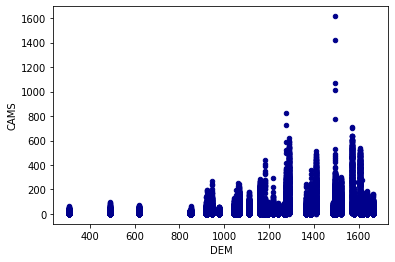

In [11]:
ax1 = train_df.plot.scatter(x='DEM', y='CAMS', c='DarkBlue')

Association of CAMS with lon:

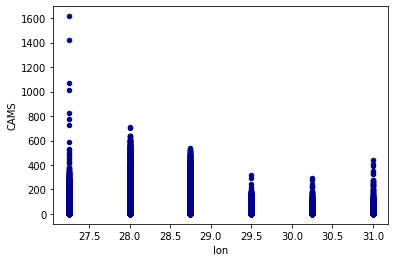

In [12]:
ax2 = train_df.plot.scatter(x='lon', y='CAMS', c='DarkBlue')

Association of CAMS with lat:

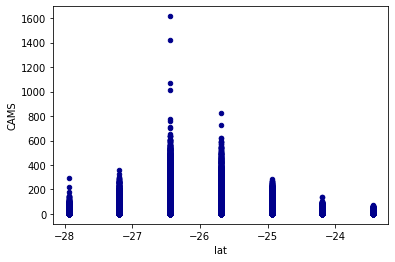

In [20]:
ax3 = train_df.plot.scatter(x='lat', y='CAMS', c='DarkBlue')

Association of CAMS with hour:

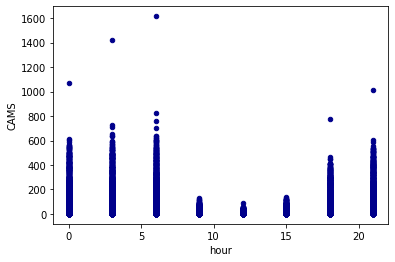

In [21]:
ax4 = train_df.plot.scatter(x='hour', y='CAMS', c='DarkBlue')

Association of CAMS with date:

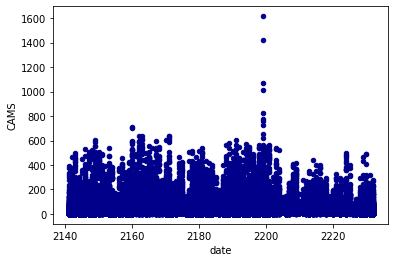

In [22]:
ax5 = train_df.plot.scatter(x='date', y='CAMS', c='DarkBlue')

Association of CAMS with relative_humidity:

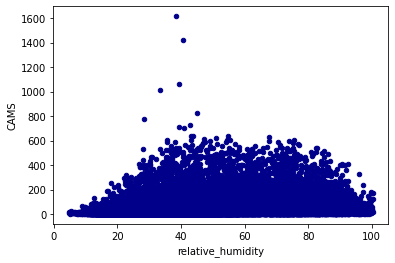

In [14]:
ax6 = train_df.plot.scatter(x='relative_humidity', y='CAMS', c='DarkBlue')

Association of CAMS with specific_rain_water_content:

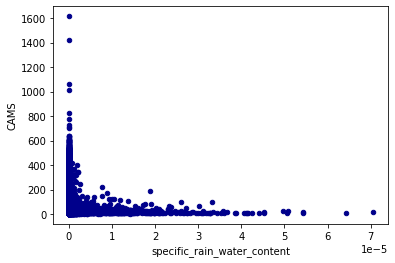

In [15]:
ax7 = train_df.plot.scatter(x='specific_rain_water_content', y='CAMS', c='DarkBlue')

Association of CAMS with wind_u:

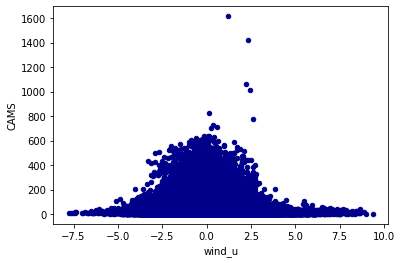

In [16]:
ax8 = train_df.plot.scatter(x='wind_u', y='CAMS', c='DarkBlue')

Association of CAMS with wind_v:

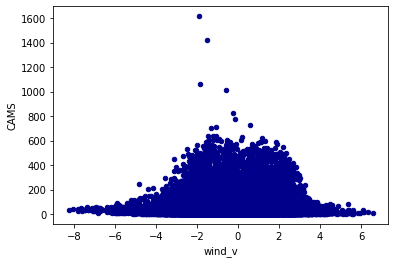

In [17]:
ax9 = train_df.plot.scatter(x='wind_v', y='CAMS', c='DarkBlue')

In [13]:
train_df

,lon,lat,CAMS,day,hour,dayhour_x,relative_humidity,dayhour_y,specific_rain_water_content,dayhour_x.1,wind_u,dayhour_y.1,wind_v,dayhour,DEM
0,27.25,-23.440001,12.745087,2141.0,0.0,214100,78.068685,214100,0.0,214100,-0.804597,214100,1.171631,214100,847.243533
1,27.25,-23.440001,16.393583,2141.0,3.0,214103,77.721987,214103,0.0,214103,-1.538880,214103,-0.511131,214103,847.243533
2,27.25,-23.440001,17.552229,2141.0,6.0,214106,75.781603,214106,0.0,214106,-0.609182,214106,-0.350456,214106,847.243533
3,27.25,-23.440001,13.509299,2141.0,9.0,214109,51.231837,214109,0.0,214109,0.907805,214109,1.200632,214109,847.243533
4,27.25,-23.440001,3.870365,2141.0,12.0,214112,40.810378,214112,0.0,214112,1.883151,214112,0.892251,214112,847.243533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30907,31.00,-27.940001,24.306879,2232.0,9.0,223209,23.474244,223209,0.0,223209,0.725448,223209,-0.991894,223209,1045.173623
30908,31.00,-27.940001,6.927214,2232.0,12.0,223212,19.462755,223212,0.0,223212,-0.900167,223212,-2.071945,223212,1045.173623
30909,31.00,-27.940001,10.846883,2232.0,15.0,223215,33.764412,223215,0.0,223215,-1.955020,223215,-2.531453,223215,1045.173623
30910,31.00,-27.940001,26.993946,2232.0,18.0,223218,49.477308,223218,0.0,223218,-0.181254,223218,-2.531994,223218,1045.173623


Rank correlation between predictors

In [18]:
# calculate the correlation matrix
corr = train_df.drop(['dayhour_x','dayhour_y','dayhour_x.1','dayhour_y.1','dayhour'], axis=1).corr(method='spearman')
round(corr, 2)

,lon,lat,CAMS,day,hour,relative_humidity,specific_rain_water_content,wind_u,wind_v,DEM
lon,1.00,0.00,-0.12,0.00,0.00,0.25,0.21,0.07,0.12,-0.17
lat,0.00,1.00,-0.24,0.00,0.00,0.01,-0.04,-0.29,0.08,-0.66
CAMS,-0.12,-0.24,1.00,-0.02,-0.12,0.31,0.01,0.06,0.01,0.29
day,0.00,0.00,-0.02,1.00,0.00,-0.12,0.13,-0.03,-0.31,0.00
hour,0.00,0.00,-0.12,0.00,1.00,-0.35,-0.11,-0.02,-0.08,0.00
relative_humidity,0.25,0.01,0.31,-0.12,-0.35,1.00,0.46,-0.31,0.10,-0.07
specific_rain_water_content,0.21,-0.04,0.01,0.13,-0.11,0.46,1.00,-0.23,0.05,-0.02
wind_u,0.07,-0.29,0.06,-0.03,-0.02,-0.31,-0.23,1.00,-0.05,0.24
wind_v,0.12,0.08,0.01,-0.31,-0.08,0.10,0.05,-0.05,1.00,-0.10
DEM,-0.17,-0.66,0.29,0.00,0.00,-0.07,-0.02,0.24,-0.10,1.00


## Modelling

Very simple RF model as a starting point. WARNING! MODELS STILL NEED TO BE TUNED!!

In [10]:
# X and Y parts
train_X = np.array(train_df.drop(['CAMS','day','dayhour_x','dayhour_y','dayhour_x.1','dayhour_y.1','dayhour','wind_v','wind_u','relative_humidity','specific_rain_water_content'], axis=1))
train_y = np.array(train_df['CAMS'])

In [11]:
# Random Forest Regression.
rf = RandomForestRegressor(n_estimators = 100) # Let's make it quick for now
# Train the model on training data
rf.fit(train_X, train_y)
pred_y = rf.predict(train_X)

In [12]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_list = list(train_df.drop(['CAMS','day','dayhour_x','dayhour_y','dayhour_x.1','dayhour_y.1','dayhour','wind_v','wind_u','relative_humidity','specific_rain_water_content'], axis=1).columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: hour                 Importance: 0.43
Variable: lat                  Importance: 0.23
Variable: lon                  Importance: 0.19
Variable: DEM                  Importance: 0.15


Resubsitution error:

Resubstitution MAE: 21.89
Resubstitution RMSE: 44.11
Resubstitution R2: 0.659


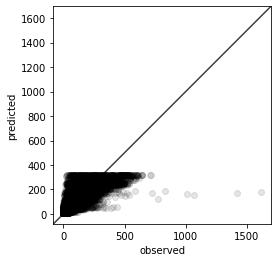

In [13]:
# Resubstitution error
print('Resubstitution MAE:', round(metrics.mean_absolute_error(train_y, pred_y), 2))
print('Resubstitution RMSE:', round(np.sqrt(metrics.mean_squared_error(train_y, pred_y)), 2))
print('Resubstitution R2:', round(metrics.r2_score(train_y, pred_y), 3))

fig, ax = plt.subplots()
ax.scatter(train_y, pred_y, color='black', alpha=0.1)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("observed")
plt.ylabel("predicted")
plt.show()

Cross-validated error:

In [11]:
# Cross-validated error (each daytime in a separate fold to emulate a new observation)
groups = np.array(train_df['dayhour'])
group_kfold = GroupKFold(n_splits=10)
group_kfold.get_n_splits(train_X, train_y, groups)

alltest_CV = np.empty((0,1), float)
allpreds_CV = np.empty((0,1), float)
allindx_CV = np.empty((0,1), float)

MAE_CV=[]
RMSE_CV=[]
R2_CV=[]
for train_index, test_index in group_kfold.split(train_X, train_y, groups):
    train_X_CV, test_X_CV = train_X[train_index], train_X[test_index]
    train_y_CV, test_y_CV = train_y[train_index], train_y[test_index]
    rf.fit(train_X_CV, train_y_CV)
    pred_y_CV = rf.predict(test_X_CV)
    alltest_CV = np.append(alltest_CV, test_y_CV)
    allpreds_CV = np.append(allpreds_CV, pred_y_CV)
    allindx_CV =  np.append(allindx_CV, train_index)
    MAE_CV.append(round(metrics.mean_absolute_error(test_y_CV, pred_y_CV), 2))
    RMSE_CV.append(round(np.sqrt(metrics.mean_squared_error(test_y_CV, pred_y_CV)), 2))
    R2_CV.append(round(metrics.r2_score(test_y_CV, pred_y_CV), 3))

CV MAE: 22.21
CV RMSE: 44.64
CV R2: 0.65


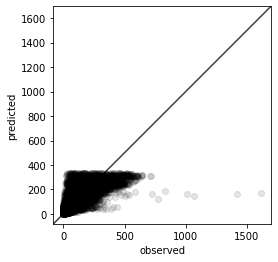

In [12]:
# Metrics
print('CV MAE:', round(statistics.mean(MAE_CV), 2))
print('CV RMSE:', round(statistics.mean(RMSE_CV), 2))
print('CV R2:', round(statistics.mean(R2_CV), 2))

fig, ax = plt.subplots()
ax.scatter(alltest_CV, allpreds_CV, color='black', alpha=0.1)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.xlabel("observed")
plt.ylabel("predicted")
plt.show()

## Model assessment (stations)

Create target grid for the AOI (10 km)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


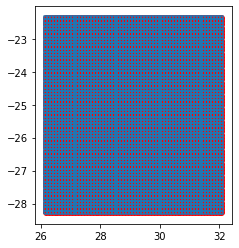

In [14]:
# Prepare grid
bounds_down = list(cams_train_eop.bbox)
res_down = bbox_to_dimensions(cams_train_eop.bbox, 10000)
res_down = (bounds_down[2]-bounds_down[0])/res_down[0]
bounds_down = geometry.box(bounds_down[0], bounds_down[1], bounds_down[2], bounds_down[3])
bounds_down = gpd.GeoDataFrame({"id":1,"geometry":[bounds_down]}, crs="EPSG:4326")
CAMS_grid_down = polygrid(bounds_down, res_down, 4326)
CAMS_centroids_down = gpd.GeoDataFrame(geometry= CAMS_grid_down.centroid)

del cams_train_eop

# Show it
p = CAMS_grid_down.boundary.plot()
CAMS_centroids_down.plot(ax=p, color='red')
plt.show()


### Prepare station data

In [15]:
pm25_gt = gpd.read_file(str(DATA_DIR/AOIS[0]/'ground_air_quality'/'PM25'/'PM25_africa_ground.shp'))
pm25_gt['geometry_wkt'] = pm25_gt['geometry'].apply(lambda geom: geom.wkt) 


In [16]:
pm25_gt['geometry_wkt'] = pm25_gt['geometry'].apply(lambda geom: geom.wkt) 
pm25g_gt = pm25_gt.groupby(['SITE_LONGI','SITE_LATIT'])

pm25_gt_min = pm25g_gt.min()
pm25_gt_min['geometry'] = pm25_gt_min['geometry_wkt'].apply(lambda x: wkt.loads(x))
pm25_gt_min.drop(columns='geometry_wkt', inplace=True)
pm25_gt_min.head()

,,Date,AirQuality,geometry
SITE_LONGI,SITE_LATIT,,,
26.846694,-26.854722,2140,8.403,POINT (26.84669 -26.85472)
27.391605,-24.591058,2140,1.207,POINT (27.39160 -24.59106)
27.722316,-23.681918,2140,2.655,POINT (27.72232 -23.68192)
27.841083,-26.587917,2140,16.898,POINT (27.84108 -26.58792)
27.855778,-26.845083,2140,12.382,POINT (27.85578 -26.84508)


In [28]:
for i, point in enumerate(pm25_gt['geometry']):
    pm25_gt.loc[i,'lon'] = round(point.xy[0][0],6)
    pm25_gt.loc[i,'lat'] = round(point.xy[1][0],6)
    
pm25_gt.head()

,Date,SITE_LATIT,SITE_LONGI,AirQuality,geometry,geometry_wkt,lon,lat
0,2140,-26.845083,27.855778,34.970,POINT (27.85578 -26.84508),POINT (27.855778 -26.845083),27.855778,-26.845083
1,2141,-26.845083,27.855778,21.456,POINT (27.85578 -26.84508),POINT (27.855778 -26.845083),27.855778,-26.845083
2,2142,-26.845083,27.855778,42.054,POINT (27.85578 -26.84508),POINT (27.855778 -26.845083),27.855778,-26.845083
3,2144,-26.845083,27.855778,15.503,POINT (27.85578 -26.84508),POINT (27.855778 -26.845083),27.855778,-26.845083
4,2147,-26.845083,27.855778,45.339,POINT (27.85578 -26.84508),POINT (27.855778 -26.845083),27.855778,-26.845083


### Extract predictor data at station locations and times

#### Prepare DEM with 10km CAMS

In [17]:
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_train_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                            filename='DEM_1km.tif',
                           no_data_value=128)
dem_train_eop

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(614, 656, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((26.56263888888889, -28.18263888888889), (31.747083333333336, -23.24763888888889)), crs=CRS('4326'))
  timestamp: []
)

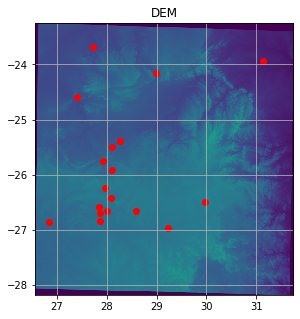

In [18]:
fig, ax = plt.subplots(figsize=(6,5))

draw_feature(ax=ax, eopatch=dem_train_eop, 
             feature=(FeatureType.DATA_TIMELESS, 'DEM'), 
             vmin=0, vmax=4000, cmap=plt.cm.viridis, time_idx=None)
pm25_gt_min.plot(ax=ax, color='r', marker='o');


In [19]:
# Perform zonal statistics - mean altitude per CAMS pixel
src = rio.open(str(dem_train_dir) + '/DEM_1km.tif')
affine = src.transform
array = dem_train_eop.data_timeless['DEM']
array = array[:, :, 0]
dem_grid_10km = CAMS_grid_down
zstats = zonal_stats(dem_grid_10km, array, affine=affine, stats="mean", nodata=np.nan)
vals = []
for index, value in enumerate(zstats):
    vals.append(value['mean'])
    
dem_grid_10km['elevation'] = vals

In [20]:
# Now we can rasterize
minx, miny, maxx, maxy = CAMS_grid_down.geometry.total_bounds
sizey = round((maxy-miny)/res_down)
sizex = round((maxx-minx)/res_down)
transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
shapes = ((geom, value) for geom, value in zip(dem_grid_10km.geometry, dem_grid_10km['elevation']))

dem10km = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
dem10km
export_geotiff(str(dem_train_dir) + '/DEM_CAMS_10km.tif', dem10km, transform, 4326)

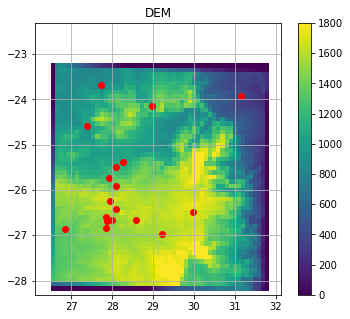

In [21]:
# Read and visualize
dem_train_dir = DATA_DIR/AOIS[0]/'DEM'
dem_train_eop = load_tiffs(datapath=dem_train_dir,
                           feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                           filename='DEM_CAMS_10km.tif')

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=dem_train_eop,
                  feature=(FeatureType.DATA_TIMELESS, 'DEM'),
                  time_idx=None,
                  vmin=0, vmax=1800)
pm25_gt_min.plot(ax=ax, color='r', marker='o');
fig.colorbar(fh, ax=ax);

#### Extract DEM at stations

In [22]:
# Extract DEM
raster_path = str(dem_train_dir) + '/DEM_CAMS_10km.tif'
dem_10km_df = extract_points_from_raster(pm25_gt_min, raster_path, 'DEM')
dem_10km_df = dem_10km_df.dropna()
station_dem_10km_df = dem_10km_df.drop('raster', 1)

#### Prepare ERA5 with 10km CAMS

In [8]:
# load ERA5 
era5_train_dir = DATA_DIR/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_train_dir))

# Load data
era5_eops = [load_tiffs(era5_train_dir/era5_p, 
                        (FeatureType.DATA, era5_p), 
                        offset=OFFSET, 
                        image_dtype=np.float32,
                        data_source='era5') 
             for era5_p in era5_products]

# Merge into one EOPS
era5_eop = EOPatch(data={'relative_humidity': era5_eops[0].data['relative_humidity'], 
                         'specific_rain_water_content': era5_eops[1].data['specific_rain_water_content'],
                        'wind_u': era5_eops[2].data['wind_u'],
                        'wind_v': era5_eops[3].data['wind_v']},
                   meta_info={'Names_relative_humidity': era5_eops[0].meta_info['Names'],
                              'Names_specific_rain_water_content': era5_eops[1].meta_info['Names'],
                             'Names_wind_u': era5_eops[2].meta_info['Names'],
                             'Names_wind_v': era5_eops[3].meta_info['Names']},
                     timestamp=era5_eops[0].timestamp,
                     bbox=era5_eops[0].bbox)
del era5_eops
era5_eop

EOPatch(
  data: {
    relative_humidity: numpy.ndarray(shape=(2208, 17, 18, 1), dtype=float32)
    specific_rain_water_content: numpy.ndarray(shape=(2208, 17, 18, 1), dtype=float32)
    wind_u: numpy.ndarray(shape=(2208, 17, 18, 1), dtype=float32)
    wind_v: numpy.ndarray(shape=(2208, 17, 18, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    Names_relative_humidity: ['ERA5_rh_day2141_h00.tif', ..., 'ERA5_rh_day2232_h23.tif'], length=2208
    Names_specific_rain_water_content: ['ERA5_srwc_day2141_h00.tif', ..., 'ERA5_srwc_day2232_h23.tif'], length=2208
    Names_wind_u: ['ERA5_u_day2141_h00.tif', ..., 'ERA5_u_day2232_h23.tif'], length=2208
    Names_wind_v: ['ERA5_v_day2141_h00.tif', ..., 'ERA5_v_day2232_h23.tif'], length=2208
  }
  bbox: BBox(((26.875, -27.815000534057617), (31.375, -23.565000534057617)), crs=CRS('4326'))
  timestamp: [date

In [ ]:
# Perform zonal statistics - ERA5 products per CAMS pixel
# Rastrize the new CAMS zonal stats and save them on disk


era5_location=  str(DATA_DIR/AOIS[0])+'/era5'

## location of exported tiff (ERA5 matching CAMS grid)
era5_cams_location = str(DATA_DIR/AOIS[0])+'/rastrize_era5_cams10km'
if not os.path.isdir(era5_cams_location):
    os.makedirs(era5_cams_location)
    for i in era5_products:
        os.mkdir(era5_cams_location + '/' + i)    

for era5_p in era5_products:
    i=0
    for era5_path in glob.glob(str(era5_location) + '/' + era5_p + '/' +  '*.tif'):
        src = rio.open(era5_path)
        affine = src.transform
        array = era5_eop.data[era5_p][i]
        array = array[:, :, 0]
        era5_grid = CAMS_grid_down
        era5_stats = zonal_stats(era5_grid, array, affine=affine, stats="mean", nodata=np.nan)
        
        vals = []
        for index, value in enumerate(era5_stats):
            vals.append(value['mean'])
            
        era5_grid[era5_p] = vals
        
        # rasterize
        minx, miny, maxx, maxy = CAMS_grid_down.geometry.total_bounds
        sizey = round((maxy-miny)/res_down)
        sizex = round((maxx-minx)/res_down)

        transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
        shapes = ((geom, value) for geom, value in zip(era5_grid.geometry, era5_grid[era5_p]))
        era5 = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
        tiffname = era5_eop.meta_info['Names_'+ era5_p][i]
        export_geotiff(str(era5_cams_location) + '/' +era5_p + '/'+ tiffname, era5, transform, 4326)

    
        i+=1

del era5_eop

In [ ]:
## Read rastraized CAMS 

# Prepare directory and product list
era5_train_dir = DATA_DIR/AOIS[0]/'era5'
era5_products = sorted(os.listdir(era5_train_dir))

era5_cams_location = str(DATA_DIR/AOIS[0])+'/rastrize_era5_cams10km'
ras_era5_location=Path(era5_cams_location)

# Load data
ras10km_era5_eops = [load_tiffs(ras_era5_location/era5_p, 
                        (FeatureType.DATA, era5_p), 
                        offset=OFFSET, 
                        image_dtype=np.float32,
                        data_source='era5') 
             for era5_p in era5_products]



# Merge into one EOPS
ras10km_era5_eop = EOPatch(data={'relative_humidity': ras_era5_eops[0].data['relative_humidity'], 
                              'specific_rain_water_content': ras_era5_eops[1].data['specific_rain_water_content'],
                              'wind_u': ras_era5_eops[2].data['wind_u'],
                              'wind_v': ras_era5_eops[3].data['wind_v']},
                        meta_info={'Names_relative_humidity': ras_era5_eops[0].meta_info['Names'],
                                   'Names_specific_rain_water_content':ras_era5_eops[1].meta_info['Names'],
                                   'Names_wind_u': ras_era5_eops[2].meta_info['Names'],
                                   'Names_wind_v': ras_era5_eops[3].meta_info['Names']},
                        timestamp= ras_era5_eops[0].timestamp,
                        bbox= ras_era5_eops[0].bbox)

del ras10km_era5_eops
ras10km_era5_eop

In [ ]:
## plot rastraized CAMS 

fig, axs = plt.subplots(figsize=(25, 5), ncols=4)

time_idx = 1

normalisations = [dict(vmin=np.min(ras10km_era5_eop.data[era5_p]), 
                       vmax=np.max(ras10km_era5_eop.data[era5_p])) 
                  for era5_p in era5_products]

for nn, (fname, norm) in enumerate(zip(era5_products, normalisations)):
    fh = draw_feature(ax=axs[nn], eopatch=ras10km_era5_eop, 
                      feature=(FeatureType.DATA, fname),
                      time_idx=time_idx, 
                      **norm,
                      alpha=.9, cmap=plt.cm.jet)
    fig.colorbar(fh, ax=axs[nn])

Compute predictions at stations locations and times

Comparison of original CAMS (daily average) with station data

Comparison of downscaled CAMS (daily average) with station data

## Prediction

In [71]:
bbox_sa = gpd.read_file('AOIs_bboxes/SouthAfrica/South_Africa_test.shp')

In [47]:
cams_pm25_test_dir = Path('validation_dataset_south_africa/South_Africa/CAMS/PM2_5')
dates_sa_pm25 = pd.read_csv('SA-date-PM25.txt')
dates_sa_pm25

,Day,time
0,2150,h12
1,2153,h12
2,2161,h12
3,2170,h12
4,2178,h12
5,2180,h12
6,2186,h12
7,2190,h12
8,2196,h12
9,2200,h12


In [44]:
day, time = dates_sa_pm25.iloc[0]

In [95]:
## Prepare the test images
input_filenames = []
for index in dates_sa_pm25.index:
    day, time = dates_sa_pm25.iloc[index]
    input_filename = f'CAMS_PM2_5_day{day}_{time.split(" ")[-1]}.tif'
    input_filenames.append(input_filename)

input_filenames

['CAMS_PM2_5_day2150_h12.tif',
 'CAMS_PM2_5_day2153_h12.tif',
 'CAMS_PM2_5_day2161_h12.tif',
 'CAMS_PM2_5_day2170_h12.tif',
 'CAMS_PM2_5_day2178_h12.tif',
 'CAMS_PM2_5_day2180_h12.tif',
 'CAMS_PM2_5_day2186_h12.tif',
 'CAMS_PM2_5_day2190_h12.tif',
 'CAMS_PM2_5_day2196_h12.tif',
 'CAMS_PM2_5_day2200_h12.tif']

#### Extract DEM

In [96]:
# Extract DEM
raster_path = str(dem_train_dir) + '/DEM_CAMS_10km.tif'
dem_10km_df = extract_points_from_raster(CAMS_centroids_down, raster_path, 'DEM')
dem_10km_df = dem_10km_df.dropna()
dem_10km_df = dem_10km_df.drop('raster', 1)

#### Note 
There are 0 values of extracted DEM

In [97]:
dem_10km_df

,lon,lat,DEM
253,26.567623,-23.249427,0.0
254,26.567623,-23.347787,0.0
255,26.567623,-23.446148,0.0
256,26.567623,-23.544509,0.0
257,26.567623,-23.642869,0.0
...,...,...,...
3532,31.780738,-27.774017,0.0
3533,31.780738,-27.872378,0.0
3534,31.780738,-27.970738,0.0
3535,31.780738,-28.069099,0.0


In [110]:
## Create submission file

submission_dir = Path('test-submission')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(submission_dir/aoi/product):
            os.makedirs(submission_dir/aoi/product)
            
visulize_dir = Path('test-visulize')
for aoi in AOIS:
    for product in ['NO2', 'PM2.5']:
        if not os.path.exists(visulize_dir/aoi/product):
            os.makedirs(visulize_dir/aoi/product)

#### Predict UPSCALED CAMS VALUES 

In [113]:
target_resolution = 10000 # target resolution in metres
target_size = bbox_to_dimensions(test_img.bbox, target_resolution)


bbox_sa.to_crs(epsg=4326, inplace=True)
bbox_sa.to_file('sa-bbox-wgs84.shp', driver='ESRI Shapefile')

test_df = dem_10km_df

for input_filename in input_filenames:
    test_df['day']=np.nan
    test_df['hour']=np.nan
    test_df['dayhour']=""
    
    for i in range(test_df.shape[0]):
        tiff_name = input_filename
        day, hour = tiff_name.split('_day')[-1].split('_')
        test_df.iat[i,test_df.columns.get_loc('day')] = day
        test_df.iat[i,test_df.columns.get_loc('hour')] = hour[1:3]
        test_df.iat[i,test_df.columns.get_loc('dayhour')] = str(day)+str(hour[1:3])
        

    # X inputs
    test_X = np.array(test_df.drop(['day','dayhour'], axis=1))
    
    ## PREDICTION
    predicted_CAMS = rf.predict(test_X)
    
    #test_df['predicted_CAMS'] = predicted_CAMS
    
    ## rastrize
    minx, miny, maxx, maxy = CAMS_grid_down.geometry.total_bounds
    sizey = round((maxy-miny)/res_down)
    sizex = round((maxx-minx)/res_down)
    transform = rio.transform.from_bounds(minx, miny, maxx, maxy, sizex, sizey)
    shapes = ((geom, value) for geom, value in zip(CAMS_grid_down.geometry, predicted_CAMS))
    upscaled_PM_2_5 = rio.features.rasterize(shapes, out_shape=(sizey, sizex), transform=transform)
    
    ## export for prediction
    export_geotiff(str(submission_dir) + '/South_Africa/PM2.5/'+f'{day}_PM25_South_Africa.tif', upscaled_PM_2_5, transform, 4326)
    
    mask_tiff('sa-bbox-wgs84.shp', 
              submission_dir/'South_Africa'/'PM2.5'/f'{day}_PM25_South_Africa.tif', 
              submission_dir/'South_Africa'/'PM2.5'/f'{day}_PM25_South_Africa.tif')
    
    ## export them for visualization 
    export_geotiff(str(visulize_dir) + '/South_Africa/PM2.5/'+f'CAMS_PM25_day{day}_{hour}.tif', upscaled_PM_2_5, transform, 4326)
    
    mask_tiff('sa-bbox-wgs84.shp', 
              visulize_dir/'South_Africa'/'PM2.5'/f'CAMS_PM25_day{day}_{hour}.tif', 
              visulize_dir/'South_Africa'/'PM2.5'/f'CAMS_PM25_day{day}_{hour}.tif')
    
    

    

In [115]:
## load upscaled CAMS
upscaled_cams_dir = Path('test-visulize/South_Africa/PM2.5')
upscaled_img = load_tiffs(upscaled_cams_dir,
                          (FeatureType.DATA, 'PM2_5'),
                          offset=OFFSET,
                          data_source='cams')


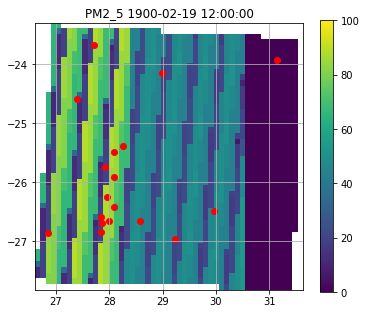

In [134]:

time_idx = 0

fig, ax = plt.subplots(figsize=(6,5))
fh = draw_feature(ax=ax, eopatch=upscaled_img,
                  feature=(FeatureType.DATA, 'PM2_5'),
                  time_idx=time_idx,
                  vmin=0, vmax=100)
pm25_gt_min.plot(ax=ax, color='r', marker='o');
fig.colorbar(fh, ax=ax);